<a href="https://colab.research.google.com/github/unica-ml/ml/blob/master/notebooks/lab06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Lab06

## Classifying Images with Pretrained ImageNet Models

We use torchvision here to download and use a pretrained ImageNet model.

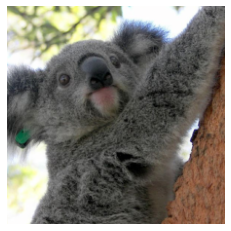

In [12]:
import io
import json

import matplotlib.pyplot as plt
import numpy as np

import requests
import torch
from PIL import Image
from torchvision import transforms, models
from decimal import Decimal

# Download and cache pretrained model from PyTorch model zoo
model = models.resnet18(pretrained=True)
# Set the model in evaluation mode (e.g., disable dropout)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# we need this later for bringing the image back to input space
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225])

# download a sample image from the web
img_path = "https://github.com/ajschumacher/imagen/blob/master/" \
           "imagen/n01882714_4157_koala_bear.jpg?raw=true"
r1 = requests.get(img_path)
img = Image.open(io.BytesIO(r1.content))

# apply transform from torchvision
input_tensor = normalize(transform(img))

# functions to show an image
def imshow(img):
    img = inv_normalize(img)
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

imshow(input_tensor)

In [13]:
# create a mini-batch as expected by the model
input_batch = input_tensor.unsqueeze(0)  

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print("Output shape", output.shape)

# softmax will rescale outputs so that the sum is 1 and we 
# can use them as probability scores
scores = torch.softmax(output, dim=1)

# take top k predictions - accuracy is usually measured with top-5
_, preds = output.topk(k=5, dim=1)

# Get the list of labels
imagenet_labels_path = "https://raw.githubusercontent.com/" \
                       "anishathalye/imagenet-simple-labels/" \
                       "master/imagenet-simple-labels.json"
r2 = requests.get(imagenet_labels_path)
labels = json.load(io.StringIO(r2.text))

# use the output as index for the labels list
for label in preds[0]:
    predicted_label = labels[label.item()]
    score = scores[0, label.item()].item()
    print("Label: {:25s} Score: {:.2f}".format(predicted_label, Decimal(score)))

Output shape torch.Size([1, 1000])
Label: koala                     Score: 0.97
Label: ring-tailed lemur         Score: 0.02
Label: indri                     Score: 0.01
Label: snow leopard              Score: 0.00
Label: titi                      Score: 0.00


## Adversarial Examples

Adversarial examples, also known as evasion attacks, are intentionally-perturbed input samples aimed to mislead classification at test time. [1,2].

These attacks are formulated as optimization problems that can be solved via gradient-based optimizers.

Here, we will compute adversarial examples by minimizing a loss function $L$ on a target label $y_t$ (different from the true class), under manipulation constraints, as given below:

$$
\begin{eqnarray}
    \mathbf x^\star \in {\arg\min}_{\mathbf x} && L(\mathbf x, y_t, \theta) \, \\
    {\rm s.t. } && \| \mathbf x- \mathbf x_0\|_2 \leq \varepsilon \, , \\
    && \mathbf x_{\rm lb} \preceq \mathbf x \preceq \mathbf x_{\rm ub} \, .
\end{eqnarray}
$$

The first constraint imposes that the adversarial perturbation will not be larger than $\varepsilon$ (measured in $\ell_2$ norm).
The second constraint is a box constraint to enforce the adversarial image not to exceed the range 0-255 (or 0-1, if the input pixels are scaled).


We solve this problem with a *projected* gradient-descent algorithm below, which iteratively projects the adversarial image on the feasible domain to ensure that the constraints remain valid.

The attack is meant to manipulate the input pixels of the initial image. To this end, we will need to explicitly account for the transform/scaling performed before passing the input sample to the neural network. In particular, at each iteration, we will map the image from the pixel space onto the transformed/scaled space, update the attack point along the gradient direction in that space, project the modified image back onto the input pixel space (using an inverse-transformation function), and apply box and $\ell_2$ constraints in the input space.

*After that, our koala will be misclassified as an acoustic guitar!*

**References**
1.   C. Szegedy et al.,  Intriguing Properties of Neural Networks, ICLR 2014, https://arxiv.org/abs/1312.6199
2.   B. Biggio et al., Evasion Attacks against Machine Learning at Test Time, ECML PKDD 2013, https://arxiv.org/abs/1708.06131 


ID: 105 Label: koala                     Score: 0.97
ID: 383 Label: ring-tailed lemur         Score: 0.02
ID: 384 Label: indri                     Score: 0.01
ID: 289 Label: snow leopard              Score: 0.00
ID: 380 Label: titi                      Score: 0.00


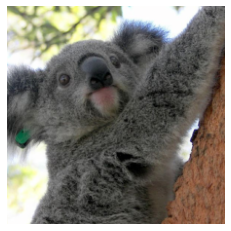

ID: 402 Label: acoustic guitar           Score: 0.93
ID: 546 Label: electric guitar           Score: 0.02
ID: 420 Label: banjo                     Score: 0.01
ID: 889 Label: violin                    Score: 0.00
ID: 281 Label: tabby cat                 Score: 0.00


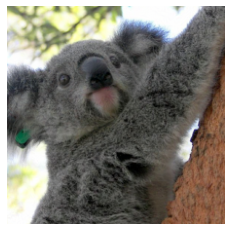

In [14]:
# ================================================================== #
#                        Adversarial Example                         #
# ================================================================== #

def predict(model, x, labels):
    with torch.no_grad():
        output = model(x)  # 1000 values (predictions on 1,000 classes)

    # softmax will rescale outputs so that the sum is 1 and we
    # can use them as probability scores
    scores = torch.softmax(output, dim=1)

    # take top k predictions - accuracy is usually measured with top-5
    _, preds = output.topk(k=5, dim=1)

    # use the output as index for the labels list
    for label in preds[0]:
        predicted_label = labels[label.item()]
        score = scores[0, label.item()].item()
        print("ID: {:3d} Label: {:25s} Score: {:.2f}"
              "".format(label.item(), predicted_label, Decimal(score)))


predict(model, input_batch, labels)
imshow(input_batch[0])

def batch_transform(batch, transform):
    return transform(batch.squeeze()).unsqueeze(0)

def l2(x):
    return x.view(x.shape[0], -1).norm(p=2, dim=1)

def perturb_iterative(x, y, model, nb_iter, eps, eta, loss_fn,
                      transform, inverse_transform,
                      clip_min=0.0, clip_max=1.0):
    """
    Iteratively maximize the loss over the input.

    :param x: input data (in feature space).
    :param y: target label.
    :param model: model to run forward pass function.
    :param nb_iter: number of iterations.
    :param eps: attack maximum l2 norm.
    :param eta: attack step size.
    :param loss_fn: loss function.
    :param transform: transformation to apply to the samples.
    :param inverse_transform: inverse process for bringing the samples
        back to input space.
    :param clip_min: mininum value per input dimension.
    :param clip_max: maximum value per input dimension.
    :return: tensor containing the perturbed input.
    """

    x_adv = x.clone()
    if torch.cuda.is_available():
        x_adv = x_adv.to('cuda')
        y = y.to('cuda')
        model = model.to('cuda')
    
    # track gradients on delta
    x_adv.requires_grad = True

    x_input_space = batch_transform(x, inverse_transform)  #x0

    for ii in range(nb_iter):
        outputs = model(x_adv)
        loss = loss_fn(outputs, y)
        loss.backward()

        grad = x_adv.grad.data
        x_adv.data = x_adv.data - eta * grad

        # ------------------------- PROJECTIONS --------------------------
        # now we have to enforce constraints in the input space
        x_adv_input_space = batch_transform(x_adv, inverse_transform)        
        # box projection in input space
        x_adv_input_space = torch.clamp(x_adv_input_space, clip_min, clip_max)
        # l2 projection in input space
        if l2(x_adv_input_space - x_input_space) > eps:
            delta = x_adv_input_space.data - x_input_space.data
            delta = delta / l2(delta)
            x_adv_input_space.data = x_input_space.data + delta.data
        # project x_adv back onto feature/normalized space
        x_adv.data = batch_transform(x_adv_input_space, transform)
        # ----------------------------------------------------------------

        # reset gradient
        x_adv.grad.data.zero_()

    # we need to detach the gradient
    return x_adv.detach()


loss = torch.nn.CrossEntropyLoss()
target_label = torch.LongTensor([402])
x_adv = perturb_iterative(x=input_batch, y=target_label, model=model,
                          nb_iter=500, eps=5, eta=0.03, loss_fn=loss,
                          transform=normalize,
                          inverse_transform=inv_normalize,
                          clip_min=0.0,
                          clip_max=1.0)

predict(model, x_adv, labels)
imshow(x_adv[0])